# Lens Finding

In [2]:
!gdown 1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5

Downloading...
From (original): https://drive.google.com/uc?id=1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5
From (redirected): https://drive.google.com/uc?id=1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5&confirm=t&uuid=6128ddb5-cf37-4f7c-9eaa-3025a22f90a7
To: /content/lens-finding-test.zip
100% 2.11G/2.11G [00:49<00:00, 43.0MB/s]


In [ ]:
!unzip /content/lens-finding-test.zip

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import ConvNeXt_Base_Weights
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from tqdm import tqdm
import os
import glob
from PIL import Image
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

In [7]:
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Memory cached: {torch.cuda.memory_cached(0) / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA L4
Memory allocated: 0.00 GB
Memory cached: 0.00 GB


<ipython-input-8-bf90bd893c2b>:5: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"Memory cached: {torch.cuda.memory_cached(0) / 1e9:.2f} GB")


In [9]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [9]:
class MoESelfAttention2d(nn.Module):
    def __init__(self, in_channels, num_experts=4, dropout=0.2, temperature=0.1):
        super().__init__()
        self.num_experts = num_experts
        self.temperature = temperature

        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
                nn.GELU(),
                nn.Conv2d(in_channels // 2, in_channels, kernel_size=3, padding=1)
            ) for _ in range(num_experts)
        ])

        self.router = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, num_experts, bias=False)
        )

        self.dropout = nn.Dropout2d(dropout)
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        B, C, H, W = x.shape
        orig_x = x

        router_logits = self.router(x)
        if self.training:
            eps = 1e-20
            U = torch.rand(router_logits.shape, device=x.device)
            gumbel = -torch.log(-torch.log(U + eps) + eps)
            weights = torch.softmax((router_logits + gumbel) / self.temperature, dim=-1)
        else:
            weights = torch.softmax(router_logits / self.temperature, dim=-1)

        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x))
        expert_outputs = torch.stack(expert_outputs, dim=1)
        weights = weights.view(B, self.num_experts, 1, 1, 1)
        combined = (expert_outputs * weights).sum(dim=1)

        out = orig_x + self.dropout(combined)
        out = out.permute(0, 2, 3, 1)
        out = self.norm(out)
        out = out.permute(0, 3, 1, 2)
        return out

class GravitationalLensClassifier(nn.Module):
    def __init__(self, num_classes=2, drop_rate=0.3):
        super().__init__()
        backbone = torchvision.models.convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        self.attn1 = MoESelfAttention2d(1024)
        self.attn2 = MoESelfAttention2d(1024)

        self.head = nn.Sequential(
            nn.LayerNorm(1024),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )

        self.class_weights = torch.tensor([0.2, 0.8])

    def forward(self, x):
        with torch.amp.autocast(device_type='cuda', enabled=True):
            x = self.feature_extractor(x)
            x = self.attn1(x)
            x = self.attn2(x)
            x = x.mean(dim=[2, 3])
            return self.head(x)

In [10]:
class AdvancedAstroAugment:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
            transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(45),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.2))
        ])

    def __call__(self, img):
        return self.transform(img)


In [11]:
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [12]:
class NPYDataset(Dataset):
    def __init__(self, file_list, labels, transform=None, cache=True):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        self.cache = cache
        self._cache = {}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if idx in self._cache:
            img, label = self._cache[idx]
        else:
            img = np.load(self.file_list[idx])
            img = np.squeeze(img)
            if img.ndim == 1:
                side = int(np.sqrt(img.shape[0]))
                if side * side == img.shape[0]:
                    img = img.reshape((side, side))
                else:
                    raise ValueError(f"1D image of length {img.shape[0]} cannot be reshaped to square")
            if img.ndim == 2:
                img = np.stack([img] * 3, axis=-1)
            elif img.ndim == 3:
                if img.shape[0] == 1:
                    img = np.repeat(img, 3, axis=0)
                    img = np.transpose(img, (1, 2, 0))
                elif img.shape[0] == 3:
                    img = np.transpose(img, (1, 2, 0))
            else:
                raise ValueError(f"Unexpected image shape: {img.shape}")
            img = (img * 255).astype(np.uint8)
            try:
                img = Image.fromarray(img)
            except Exception as e:
                raise TypeError(f"Error converting array with shape {img.shape} to image: {e}")
            label = self.labels[idx]
            if self.cache:
                self._cache[idx] = (img, label)
        if self.transform:
            img = self.transform(img)
        return img, label


In [13]:
class AsymmetricFocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, eps=1e-7):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


In [14]:
class Trainer:
    def __init__(self, model, device, optimizer, scheduler, criterion, scaler):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.scaler = scaler

    def train_epoch(self, loader):
        self.model.train()
        total_loss = 0
        all_preds = []
        all_targets = []

        for images, targets in tqdm(loader, desc="Training", leave=False):
            images = images.to(self.device)
            targets = targets.to(self.device)

            self.optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda', enabled=True):
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.scheduler.step()

            total_loss += loss.item()
            all_preds.append(outputs.detach().cpu())
            all_targets.append(targets.detach().cpu())

        return total_loss / len(loader), torch.cat(all_preds), torch.cat(all_targets)

    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_targets = []

        for images, targets in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(self.device)
            targets = targets.to(self.device)

            outputs = self.model(images)
            loss = self.criterion(outputs, targets)

            total_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())

        return total_loss / len(loader), torch.cat(all_preds), torch.cat(all_targets)


In [15]:
def calculate_metrics(preds, targets):
    preds_softmax = torch.softmax(preds, dim=1)
    probs = preds_softmax.numpy()
    pred_labels = preds_softmax.argmax(dim=1).numpy()
    targets = targets.numpy()

    metrics = {
        'accuracy': accuracy_score(targets, pred_labels),
        'roc_auc': roc_auc_score(targets, probs[:, 1]),
        'precision_recall_fscore': precision_recall_fscore_support(targets, pred_labels, average='binary'),
        'confusion_matrix': confusion_matrix(targets, pred_labels),
        'class_report': classification_report(targets, pred_labels, target_names=['non-lens', 'lens'])
    }
    return metrics

def load_dataset_paths(data_root='/content'):
    classes = {'train_nonlenses': 0, 'train_lenses': 1}
    file_paths = []
    labels = []
    for cls_name, label in classes.items():
        folder = os.path.join(data_root, cls_name)
        files = glob.glob(os.path.join(folder, "*.npy"))
        file_paths.extend(files)
        labels.extend([label] * len(files))
    labels = np.array(labels)
    return file_paths, labels

In [16]:
def run_experiment(config):
    file_paths, labels = load_dataset_paths()
    skf = StratifiedKFold(n_splits=config['n_splits'], shuffle=True, random_state=42)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for fold, (train_idx, val_idx) in enumerate(skf.split(file_paths, labels)):
        print(f"\n=== Fold {fold+1}/{config['n_splits']} ===")

        train_set = NPYDataset([file_paths[i] for i in train_idx],
                               labels[train_idx],
                               transform=AdvancedAstroAugment())
        val_set = NPYDataset([file_paths[i] for i in val_idx],
                             labels[val_idx],
                             transform=val_transform)

        train_labels = labels[train_idx]
        class_counts = np.bincount(train_labels)
        weights = 1. / class_counts
        samples_weights = weights[train_labels]
        sampler = torch.utils.data.WeightedRandomSampler(
            samples_weights, len(samples_weights), replacement=True)

        train_loader = DataLoader(train_set, batch_size=config['batch_size'],
                                  sampler=sampler, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_set, batch_size=config['batch_size'] * 2,
                                shuffle=False, num_workers=4, pin_memory=True)

        model = GravitationalLensClassifier()
        model.class_weights = torch.tensor(config['class_weights']).to(device)
        model.to(device)

        optimizer = optim.AdamW(model.parameters(), lr=config['lr'],
                                weight_decay=config['weight_decay'])
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=config['max_lr'],
            steps_per_epoch=len(train_loader), epochs=config['epochs'])

        criterion = AsymmetricFocalLoss(alpha=0.8, gamma=2.0)

        scaler = torch.amp.GradScaler()
        trainer = Trainer(model, device, optimizer, scheduler, criterion, scaler)

        best_score = 0
        for epoch in range(config['epochs']):
            print(f"\nEpoch {epoch+1}/{config['epochs']}")

            train_loss, train_preds, train_targets = trainer.train_epoch(train_loader)
            train_metrics = calculate_metrics(train_preds, train_targets)

            val_loss, val_preds, val_targets = trainer.evaluate(val_loader)
            val_metrics = calculate_metrics(val_preds, val_targets)

            if val_metrics['roc_auc'] > best_score:
                best_score = val_metrics['roc_auc']
                torch.save(model.state_dict(), f"best_fold{fold}.pth")

            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Val ROC AUC: {val_metrics['roc_auc']:.4f}")
            print(f"Confusion Matrix:\n{val_metrics['confusion_matrix']}")
            print(f"Classification Report:\n{val_metrics['class_report']}")

    ensemble_models = []
    for f in range(config['n_splits']):
        model = GravitationalLensClassifier()
        model.load_state_dict(torch.load(f"best_fold{f}.pth"))
        model.to(device)
        ensemble_models.append(model)
    return ensemble_models

config = {
    'n_splits': 3,
    'epochs': 10,
    'batch_size': 32,
    'lr': 1e-4,
    'max_lr': 3e-4,
    'weight_decay': 0.05,
    'class_weights': [0.53, 8.78],
    'patience': 5
}

ensemble = run_experiment(config)


=== Fold 1/3 ===


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 197MB/s]



Epoch 1/10


Train Loss: 0.0528 | Val Loss: 0.0231
Val ROC AUC: 0.9805
Confusion Matrix:
[[9229  330]
 [  80  496]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       0.99      0.97      0.98      9559
        lens       0.60      0.86      0.71       576

    accuracy                           0.96     10135
   macro avg       0.80      0.91      0.84     10135
weighted avg       0.97      0.96      0.96     10135


Epoch 2/10


Train Loss: 0.0428 | Val Loss: 0.0331
Val ROC AUC: 0.9873
Confusion Matrix:
[[8959  600]
 [  19  557]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.94      0.97      9559
        lens       0.48      0.97      0.64       576

    accuracy                           0.94     10135
   macro avg       0.74      0.95      0.80     10135
weighted avg       0.97      0.94      0.95     10135


Epoch 3/10


Train Loss: 0.0429 | Val Loss: 0.0601
Val ROC AUC: 0.9844
Confusion Matrix:
[[8632  927]
 [  17  559]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.90      0.95      9559
        lens       0.38      0.97      0.54       576

    accuracy                           0.91     10135
   macro avg       0.69      0.94      0.75     10135
weighted avg       0.96      0.91      0.93     10135


Epoch 4/10


Train Loss: 0.0402 | Val Loss: 0.0208
Val ROC AUC: 0.9896
Confusion Matrix:
[[9273  286]
 [  46  530]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.97      0.98      9559
        lens       0.65      0.92      0.76       576

    accuracy                           0.97     10135
   macro avg       0.82      0.95      0.87     10135
weighted avg       0.98      0.97      0.97     10135


Epoch 5/10


Train Loss: 0.0363 | Val Loss: 0.0659
Val ROC AUC: 0.9891
Confusion Matrix:
[[8278 1281]
 [   8  568]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.87      0.93      9559
        lens       0.31      0.99      0.47       576

    accuracy                           0.87     10135
   macro avg       0.65      0.93      0.70     10135
weighted avg       0.96      0.87      0.90     10135


Epoch 6/10


Train Loss: 0.0298 | Val Loss: 0.0163
Val ROC AUC: 0.9868
Confusion Matrix:
[[9381  178]
 [ 104  472]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       0.99      0.98      0.99      9559
        lens       0.73      0.82      0.77       576

    accuracy                           0.97     10135
   macro avg       0.86      0.90      0.88     10135
weighted avg       0.97      0.97      0.97     10135


Epoch 7/10


Train Loss: 0.0263 | Val Loss: 0.0221
Val ROC AUC: 0.9913
Confusion Matrix:
[[9255  304]
 [  29  547]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.97      0.98      9559
        lens       0.64      0.95      0.77       576

    accuracy                           0.97     10135
   macro avg       0.82      0.96      0.87     10135
weighted avg       0.98      0.97      0.97     10135


Epoch 8/10


Train Loss: 0.0207 | Val Loss: 0.0184
Val ROC AUC: 0.9926
Confusion Matrix:
[[9276  283]
 [  26  550]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.97      0.98      9559
        lens       0.66      0.95      0.78       576

    accuracy                           0.97     10135
   macro avg       0.83      0.96      0.88     10135
weighted avg       0.98      0.97      0.97     10135


Epoch 9/10


Train Loss: 0.0174 | Val Loss: 0.0188
Val ROC AUC: 0.9928
Confusion Matrix:
[[9323  236]
 [  27  549]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.98      0.99      9559
        lens       0.70      0.95      0.81       576

    accuracy                           0.97     10135
   macro avg       0.85      0.96      0.90     10135
weighted avg       0.98      0.97      0.98     10135


Epoch 10/10


Train Loss: 0.0167 | Val Loss: 0.0169
Val ROC AUC: 0.9926
Confusion Matrix:
[[9355  204]
 [  31  545]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.98      0.99      9559
        lens       0.73      0.95      0.82       576

    accuracy                           0.98     10135
   macro avg       0.86      0.96      0.91     10135
weighted avg       0.98      0.98      0.98     10135


=== Fold 2/3 ===

Epoch 1/10


Train Loss: 0.0520 | Val Loss: 0.0560
Val ROC AUC: 0.9849
Confusion Matrix:
[[8604  954]
 [  14  563]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.90      0.95      9558
        lens       0.37      0.98      0.54       577

    accuracy                           0.90     10135
   macro avg       0.68      0.94      0.74     10135
weighted avg       0.96      0.90      0.92     10135


Epoch 2/10


Train Loss: 0.0417 | Val Loss: 0.0221
Val ROC AUC: 0.9877
Confusion Matrix:
[[9183  375]
 [  35  542]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.96      0.98      9558
        lens       0.59      0.94      0.73       577

    accuracy                           0.96     10135
   macro avg       0.79      0.95      0.85     10135
weighted avg       0.97      0.96      0.96     10135


Epoch 3/10


Train Loss: 0.0420 | Val Loss: 0.0211
Val ROC AUC: 0.9872
Confusion Matrix:
[[9204  354]
 [  39  538]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.96      0.98      9558
        lens       0.60      0.93      0.73       577

    accuracy                           0.96     10135
   macro avg       0.80      0.95      0.86     10135
weighted avg       0.97      0.96      0.97     10135


Epoch 4/10


Train Loss: 0.0393 | Val Loss: 0.0410
Val ROC AUC: 0.9877
Confusion Matrix:
[[9034  524]
 [  26  551]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.95      0.97      9558
        lens       0.51      0.95      0.67       577

    accuracy                           0.95     10135
   macro avg       0.75      0.95      0.82     10135
weighted avg       0.97      0.95      0.95     10135


Epoch 5/10


Train Loss: 0.0354 | Val Loss: 0.0181
Val ROC AUC: 0.9895
Confusion Matrix:
[[9206  352]
 [  31  546]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.96      0.98      9558
        lens       0.61      0.95      0.74       577

    accuracy                           0.96     10135
   macro avg       0.80      0.95      0.86     10135
weighted avg       0.97      0.96      0.97     10135


Epoch 6/10


Train Loss: 0.0317 | Val Loss: 0.0231
Val ROC AUC: 0.9892
Confusion Matrix:
[[9192  366]
 [  27  550]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.96      0.98      9558
        lens       0.60      0.95      0.74       577

    accuracy                           0.96     10135
   macro avg       0.80      0.96      0.86     10135
weighted avg       0.97      0.96      0.97     10135


Epoch 7/10


Train Loss: 0.0252 | Val Loss: 0.0182
Val ROC AUC: 0.9933
Confusion Matrix:
[[9260  298]
 [  29  548]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.97      0.98      9558
        lens       0.65      0.95      0.77       577

    accuracy                           0.97     10135
   macro avg       0.82      0.96      0.88     10135
weighted avg       0.98      0.97      0.97     10135


Epoch 8/10


Train Loss: 0.0212 | Val Loss: 0.0214
Val ROC AUC: 0.9928
Confusion Matrix:
[[9201  357]
 [  26  551]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.96      0.98      9558
        lens       0.61      0.95      0.74       577

    accuracy                           0.96     10135
   macro avg       0.80      0.96      0.86     10135
weighted avg       0.97      0.96      0.97     10135


Epoch 9/10


Train Loss: 0.0183 | Val Loss: 0.0167
Val ROC AUC: 0.9940
Confusion Matrix:
[[9288  270]
 [  24  553]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.97      0.98      9558
        lens       0.67      0.96      0.79       577

    accuracy                           0.97     10135
   macro avg       0.83      0.97      0.89     10135
weighted avg       0.98      0.97      0.97     10135


Epoch 10/10


Train Loss: 0.0152 | Val Loss: 0.0157
Val ROC AUC: 0.9942
Confusion Matrix:
[[9329  229]
 [  24  553]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.98      0.99      9558
        lens       0.71      0.96      0.81       577

    accuracy                           0.98     10135
   macro avg       0.85      0.97      0.90     10135
weighted avg       0.98      0.98      0.98     10135


=== Fold 3/3 ===

Epoch 1/10


Train Loss: 0.0504 | Val Loss: 0.0294
Val ROC AUC: 0.9850
Confusion Matrix:
[[9093  465]
 [  37  540]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.95      0.97      9558
        lens       0.54      0.94      0.68       577

    accuracy                           0.95     10135
   macro avg       0.77      0.94      0.83     10135
weighted avg       0.97      0.95      0.96     10135


Epoch 2/10


Train Loss: 0.0431 | Val Loss: 0.1110
Val ROC AUC: 0.9800
Confusion Matrix:
[[7178 2380]
 [  10  567]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.75      0.86      9558
        lens       0.19      0.98      0.32       577

    accuracy                           0.76     10135
   macro avg       0.60      0.87      0.59     10135
weighted avg       0.95      0.76      0.83     10135


Epoch 3/10


Train Loss: 0.0419 | Val Loss: 0.0331
Val ROC AUC: 0.9858
Confusion Matrix:
[[8918  640]
 [  31  546]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.93      0.96      9558
        lens       0.46      0.95      0.62       577

    accuracy                           0.93     10135
   macro avg       0.73      0.94      0.79     10135
weighted avg       0.97      0.93      0.94     10135


Epoch 4/10


Train Loss: 0.0380 | Val Loss: 0.0410
Val ROC AUC: 0.9874
Confusion Matrix:
[[8964  594]
 [  25  552]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.94      0.97      9558
        lens       0.48      0.96      0.64       577

    accuracy                           0.94     10135
   macro avg       0.74      0.95      0.80     10135
weighted avg       0.97      0.94      0.95     10135


Epoch 5/10


Train Loss: 0.0388 | Val Loss: 0.0796
Val ROC AUC: 0.9885
Confusion Matrix:
[[8409 1149]
 [   7  570]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.88      0.94      9558
        lens       0.33      0.99      0.50       577

    accuracy                           0.89     10135
   macro avg       0.67      0.93      0.72     10135
weighted avg       0.96      0.89      0.91     10135


Epoch 6/10


Train Loss: 0.0294 | Val Loss: 0.0180
Val ROC AUC: 0.9902
Confusion Matrix:
[[9254  304]
 [  29  548]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.97      0.98      9558
        lens       0.64      0.95      0.77       577

    accuracy                           0.97     10135
   macro avg       0.82      0.96      0.87     10135
weighted avg       0.98      0.97      0.97     10135


Epoch 7/10


Train Loss: 0.0267 | Val Loss: 0.0181
Val ROC AUC: 0.9906
Confusion Matrix:
[[9342  216]
 [  46  531]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.98      0.99      9558
        lens       0.71      0.92      0.80       577

    accuracy                           0.97     10135
   macro avg       0.85      0.95      0.89     10135
weighted avg       0.98      0.97      0.98     10135


Epoch 8/10


Train Loss: 0.0211 | Val Loss: 0.0238
Val ROC AUC: 0.9919
Confusion Matrix:
[[9198  360]
 [  29  548]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.96      0.98      9558
        lens       0.60      0.95      0.74       577

    accuracy                           0.96     10135
   macro avg       0.80      0.96      0.86     10135
weighted avg       0.97      0.96      0.97     10135


Epoch 9/10


Train Loss: 0.0170 | Val Loss: 0.0198
Val ROC AUC: 0.9913
Confusion Matrix:
[[9335  223]
 [  40  537]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.98      0.99      9558
        lens       0.71      0.93      0.80       577

    accuracy                           0.97     10135
   macro avg       0.85      0.95      0.89     10135
weighted avg       0.98      0.97      0.98     10135


Epoch 10/10


Train Loss: 0.0160 | Val Loss: 0.0193
Val ROC AUC: 0.9921
Confusion Matrix:
[[9322  236]
 [  31  546]]
Classification Report:
              precision    recall  f1-score   support

    non-lens       1.00      0.98      0.99      9558
        lens       0.70      0.95      0.80       577

    accuracy                           0.97     10135
   macro avg       0.85      0.96      0.89     10135
weighted avg       0.98      0.97      0.98     10135



<ipython-input-16-bbcacfc0b386>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_fold{f}.pth"))


In [17]:
import cv2
import matplotlib.pyplot as plt

In [47]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = self._get_target_layer(target_layer)
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _get_target_layer(self, target_layer):
        if isinstance(target_layer, str):
            return dict([*self.model.named_modules()])[target_layer]
        return target_layer

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        input_tensor.requires_grad = True

        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        output[:, class_idx].backward(retain_graph=True)

        gradients = self.gradients.detach()
        activations = self.activations.detach()
        pooled_grads = torch.mean(gradients, dim=[0, 2, 3])

        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_grads[i]

        heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / np.max(heatmap)

        return heatmap

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GravitationalLensClassifier(num_classes=2).to(device)
model.load_state_dict(torch.load("/content/best_fold1_focal_submit.pth", map_location=device))
model.eval()

In [51]:
target_layer = model.attn2
gradcam = GradCAM(model, target_layer)

In [66]:
def preprocess_image(npy_file):
    image = np.load(npy_file)
    image = torch.tensor(image).unsqueeze(0)
    image = image.expand(1, 3, *image.shape[2:])
    image = image.float().to(device)
    return image

def overlay_heatmap(image_path, heatmap):
    original_img = np.load(image_path)[0]
    original_img = cv2.resize(original_img, (224, 224))

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    if original_img.ndim == 2:
        original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    superimposed_img = heatmap * 0.5 + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img

def visualize_gradcam(model, gradcam, image_path):
    input_tensor = preprocess_image(image_path)
    heatmap = gradcam.generate_cam(input_tensor)
    result_image = overlay_heatmap(image_path, heatmap)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(np.load(image_path)[0], cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(result_image[:, :, ::-1])
    plt.title("Grad-CAM Heatmap")

    plt.show()

def visualize_activations(model, image_path, num_channels=4):
    model.eval()
    input_tensor = preprocess_image(image_path)

    layers = [
        ("Feature Extractor", model.feature_extractor),
        ("Attention Module 1", model.attn1),
        ("Attention Module 2", model.attn2)
    ]

    activations = {}
    x = input_tensor
    for name, layer in layers:
        x = layer(x)
        activation = x.detach().cpu()
        activations[name] = activation

        print(f"{name} activation shape: {activation.shape}")
        print(f"Global min: {activation.min().item():.4f}, Global max: {activation.max().item():.4f}\n")

    for name, activation in activations.items():
        num_total_channels = activation.shape[1]
        channels_to_show = min(num_channels, num_total_channels)
        fig, axes = plt.subplots(1, channels_to_show, figsize=(4 * channels_to_show, 4))
        fig.suptitle(f"{name} - First {channels_to_show} Channels", fontsize=16)

        if channels_to_show == 1:
            axes = [axes]

        for i in range(channels_to_show):
            act_map = activation[0, i].numpy()
            axes[i].imshow(act_map, cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f"Channel {i}\nmin: {act_map.min():.2f}, max: {act_map.max():.2f}")
        plt.tight_layout()
        plt.show()

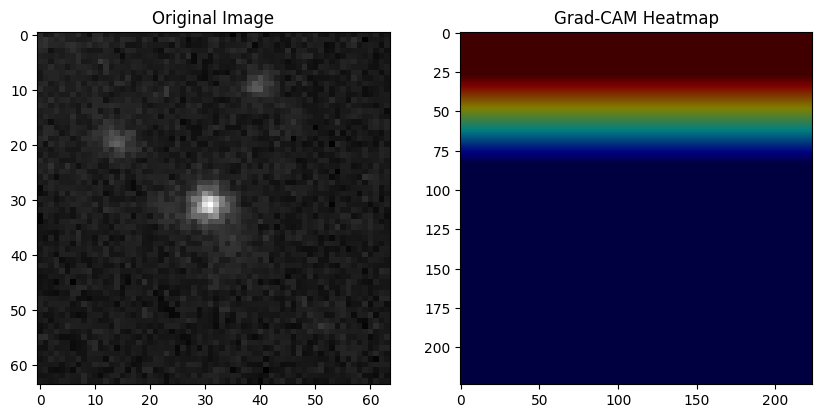

Feature Extractor activation shape: torch.Size([1, 1024, 1, 1])
Global min: -7.5263, Global max: 10.1602

Attention Module 1 activation shape: torch.Size([1, 1024, 1, 1])
Global min: -14.0157, Global max: 18.8959

Attention Module 2 activation shape: torch.Size([1, 1024, 1, 1])
Global min: -14.3787, Global max: 19.6693



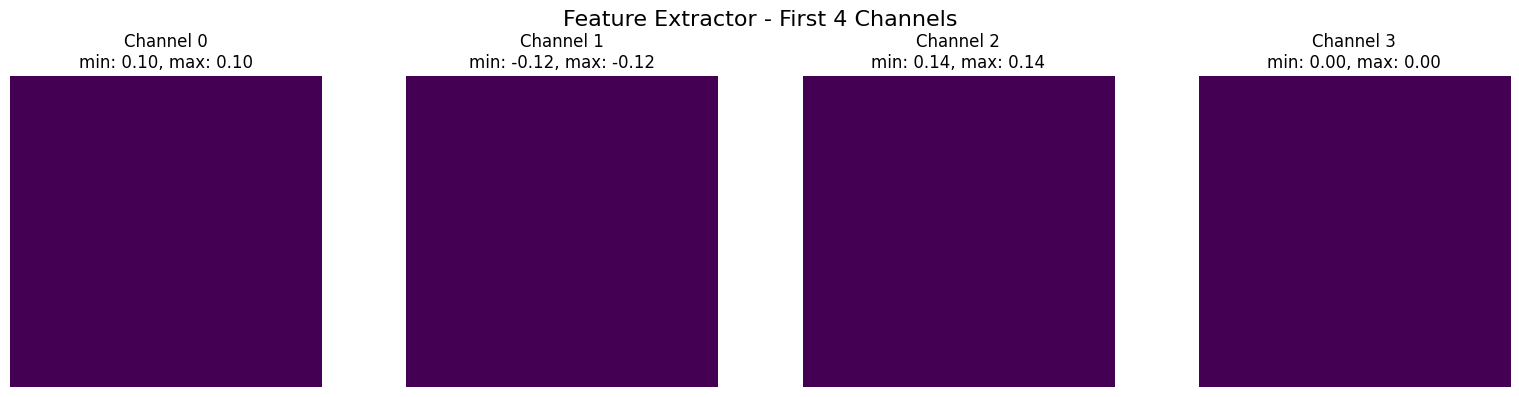

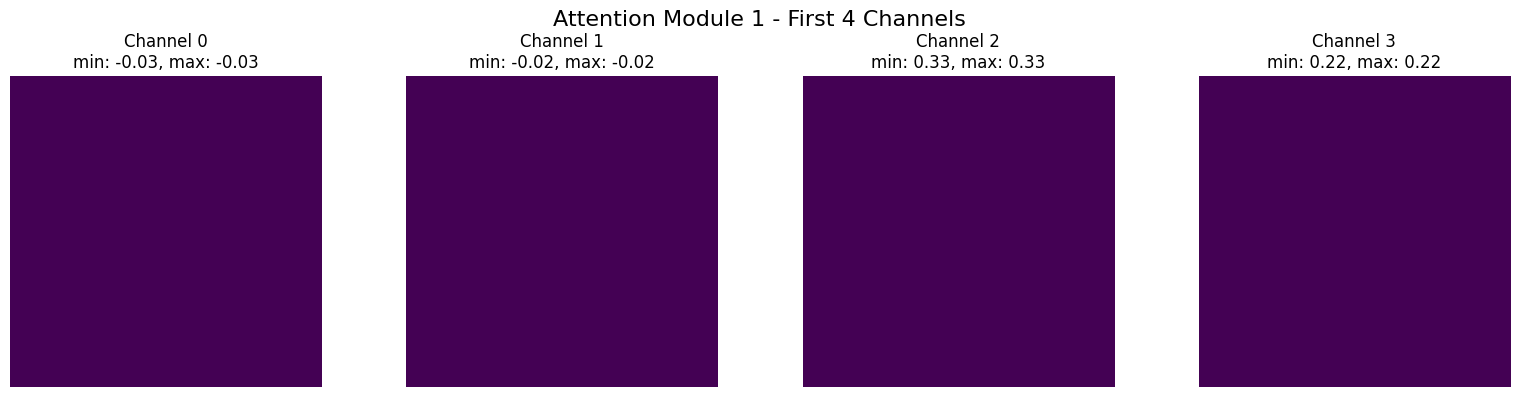

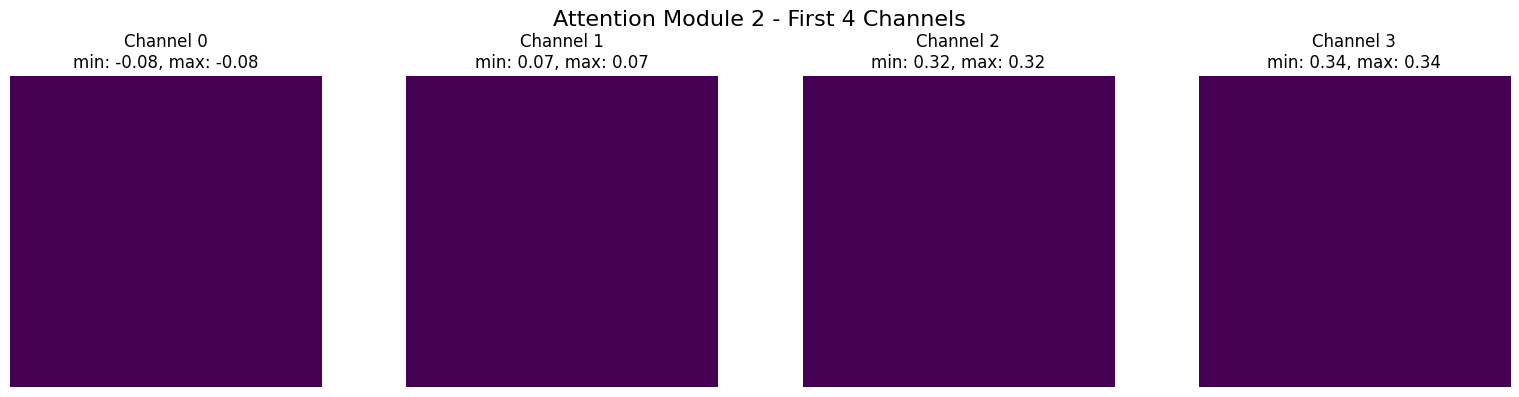

In [67]:
visualize_gradcam(model, gradcam, "/content/train_nonlenses/1.npy")
visualize_activations(model, "/content/train_nonlenses/1.npy")

In [68]:
class_labels = ["test_nonlenses", "test_lenses"]

def load_npy_image(npy_file):
    arr = np.load(npy_file)
    arr = np.squeeze(arr)

    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    elif arr.ndim == 3:
        if arr.shape[0] == 1:
            arr = np.repeat(arr, 3, axis=0)
            arr = np.transpose(arr, (1, 2, 0))
        elif arr.shape[0] == 3:
            arr = np.transpose(arr, (1, 2, 0))
    else:
        raise ValueError("Unexpected image shape: {}".format(arr.shape))

    img = Image.fromarray((arr * 255).astype(np.uint8))
    return img

def predict_npy(npy_file, model, device):
    image = load_npy_image(npy_file)

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_idx = probabilities.argmax(dim=1).item()

    predicted_label = class_labels[predicted_idx]
    return predicted_label, probabilities.cpu().numpy()

In [69]:
categories = ["test_nonlenses", "test_lenses"]

for category in categories:
    count = 0
    folder = f"/content/{category}/"
    file_list = os.listdir(folder)
    for i in tqdm(range(len(file_list)), desc=f"Processing {category}"):
        npy_file = f"{folder}{i+1}.npy"
        label, probs = predict_npy(npy_file, model, device)
        if label == category:
            count += 1

    percentage = (count / len(file_list)) * 100
    print(f"'{category}': {percentage:.2f}%")

Processing test_nonlenses: 100%|██████████| 19455/19455 [07:45<00:00, 41.83it/s]


'test_nonlenses': 97.23%


Processing test_lenses: 100%|██████████| 195/195 [00:04<00:00, 42.09it/s]

'test_lenses': 94.36%
